In [66]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils

In [67]:
#readind and preparing data ( text , label )
import os, sys
import pandas as pd
import numpy as np
df=pd.read_excel('incident13types.xlsx', header=None) ## read le file
df.columns=['tags','post']
print(df[1:5])

   tags                                               post
1    11  عند التاسعة من مساء يوم 29/9/2018 وفي محلة الط...
2     4  اقدم المدعو وليد عدنان مرعي على شتم و اهانة ال...
3    12  أقدم المدعو ناصر رضا على اصدار شك لصالح حسن اح...
4     1  الساعة 7.30 من تاريخه وفي محلة فردان شارع كرام...


In [68]:
# -*- coding: utf-8 -*-

# Arabic Transliteration based on Buckwalter
# dictionary source is buckwalter2unicode.py http://www.redhat.com/archives/fedora-extras-commits/2007-June/msg03617.html 

buck2uni = {"'": u"\u0621", # hamza-on-the-line
            "|": u"\u0622", # madda
            ">": u"\u0623", # hamza-on-'alif
            "&": u"\u0624", # hamza-on-waaw
            "<": u"\u0625", # hamza-under-'alif
            "}": u"\u0626", # hamza-on-yaa'
            "A": u"\u0627", # bare 'alif
            "b": u"\u0628", # baa'
            "p": u"\u0629", # taa' marbuuTa
            "t": u"\u062A", # taa'
            "v": u"\u062B", # thaa'
            "j": u"\u062C", # jiim
            "H": u"\u062D", # Haa'
            "x": u"\u062E", # khaa'
            "d": u"\u062F", # daal
            "*": u"\u0630", # dhaal
            "r": u"\u0631", # raa'
            "z": u"\u0632", # zaay
            "s": u"\u0633", # siin
            "$": u"\u0634", # shiin
            "S": u"\u0635", # Saad
            "D": u"\u0636", # Daad
            "T": u"\u0637", # Taa'
            "Z": u"\u0638", # Zaa' (DHaa')
            "E": u"\u0639", # cayn
            "g": u"\u063A", # ghayn
            "_": u"\u0640", # taTwiil
            "f": u"\u0641", # faa'
            "q": u"\u0642", # qaaf
            "k": u"\u0643", # kaaf
            "l": u"\u0644", # laam
            "m": u"\u0645", # miim
            "n": u"\u0646", # nuun
            "h": u"\u0647", # haa'
            "w": u"\u0648", # waaw
            "Y": u"\u0649", # 'alif maqSuura
            "y": u"\u064A", # yaa'
            "F": u"\u064B", # fatHatayn
            "N": u"\u064C", # Dammatayn
            "K": u"\u064D", # kasratayn
            "a": u"\u064E", # fatHa
            "u": u"\u064F", # Damma
            "i": u"\u0650", # kasra
            "~": u"\u0651", # shaddah
            "o": u"\u0652", # sukuun
            "`": u"\u0670", # dagger 'alif
            "{": u"\u0671", # waSla
}
def transString(string, reverse=0):
    '''Given a Unicode string, transliterate into Buckwalter. To go from
    Buckwalter back to Unicode, set reverse=1'''

    for k, v in buck2uni.items():
      if not reverse:
            string = string.replace(v, k)
      else:
            string = string.replace(k, v)

    return string


In [69]:
for i in range(len(df['post'])):
   df['post'][i]=transString(str(df['post'][i]))


C:\Users\Maya\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [70]:
print(df['post'][1:5])

1    End AltAsEp mn msA' ywm 29/9/2018 wfy mHlp AlT...
2    Aqdm AlmdEw wlyd EdnAn mrEy ElY $tm w AhAnp Al...
3    >qdm AlmdEw nASr rDA ElY ASdAr $k lSAlH Hsn AH...
4    AlsAEp 7.30 mn tAryxh wfy mHlp frdAn $ArE krAm...
Name: post, dtype: object


In [71]:
train_size = int(len(df) * .7)
print ("Train size: %d" % train_size)
print ("Test size: %d" % (len(df) - train_size))

Train size: 1668
Test size: 716


In [72]:
train_posts = df['post'][:train_size]
train_tags = df['tags'][:train_size]

test_posts = df['post'][train_size:]
test_tags = df['tags'][train_size:]

In [73]:
max_words = 50000
tokenize = text.Tokenizer(num_words=max_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', char_level=False)

In [74]:
tokenize.fit_on_texts(train_posts) # only fit on train
x_train = tokenize.texts_to_matrix(train_posts)
x_test = tokenize.texts_to_matrix(test_posts)

In [75]:
encoder = LabelEncoder()
encoder.fit(train_tags)
y_train = encoder.transform(train_tags)
y_test = encoder.transform(test_tags)

In [76]:
num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

x_train shape: (1668, 50000)
x_test shape: (716, 50000)
y_train shape: (1668, 13)
y_test shape: (716, 13)


In [77]:
batch_size = 32
epochs = 2

# Build the model
model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 1501 samples, validate on 167 samples
Epoch 1/2
1501/1501 [==============================] - 16s 10ms/step - loss: 1.4335 - acc: 0.5909 - val_loss: 0.6870 - val_acc: 0.8024
Epoch 2/2
1501/1501 [==============================] - 14s 9ms/step - loss: 0.4003 - acc: 0.9387 - val_loss: 0.4732 - val_acc: 0.8503


In [78]:

score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test accuracy:', score[1])

716/716 [==============================] - 1s 2ms/step
Test accuracy: 0.877094972400026


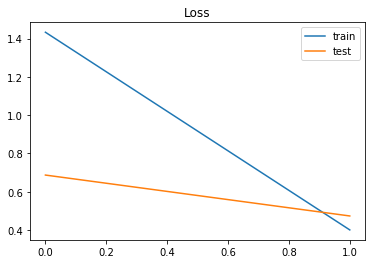

In [79]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

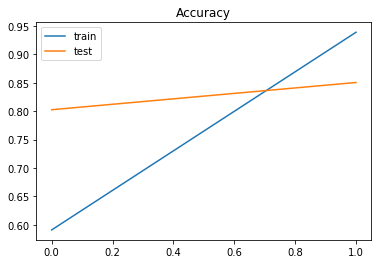

In [80]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();